In [1]:
%gui tk
%matplotlib inline

import random
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
from skimage import transform
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#to increase accuracy, all images should have the same initial pixel/µm resolution

IMAGE_HEIGHT = 416
IMAGE_WIDTH = 416
IMAGE_CHANNELS = 3
BOX_WIDTH = 15 #px
BOX_HEIGHT = 15 #px

In [3]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [4]:
# Choose directory with image and coordinate folders
data_dir = os.path.normpath(filedialog.askdirectory())

In [5]:
# Create a dataframe for images and coordinates
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
all_bounding_boxes = glob(os.path.join(data_dir, '*', '*.csv'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info, 'bounding_boxes_path': all_bounding_boxes})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [6]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
    image = np.stack([image,image,image], 2)
    return image

In [7]:
# function to read bounding boxes from files
def read_bounding_boxes(bounding_box_file):
    boxes = np.genfromtxt(bounding_box_file, delimiter = ',')
    return boxes

In [8]:
# load bounding boxes and images from files
img_df['boxes'] = img_df['bounding_boxes_path'].map(read_bounding_boxes)
img_df['images'] = img_df['img_path'].map(load_image)

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: genfromtxt: Empty input file: "C:\Users\smirnovm\Documents\Data\Labeled_Spines_With_Bounding_Boxes\spine000480\spine_bounding_boxes000480.csv"
  This is separate from the ipykernel package so we can avoid doing imports until


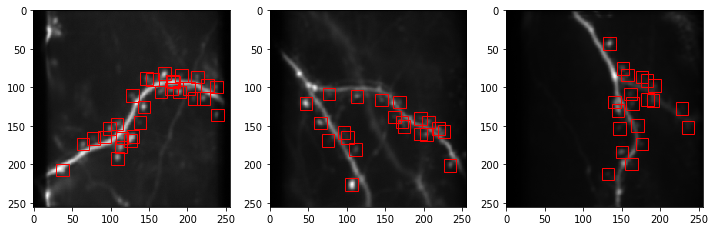

In [9]:
#Show a few sample split images with boxes
n_img = 3
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].loc[:n_img], range(n_img)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['boxes'].loc[ax_ind].shape) > 0:
        for pos in img_df['boxes'].loc[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(pos[:2],pos[2],pos[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)


In [10]:
# function to identify which images need to be split 
def flag_big_images(image):
    orig_height, orig_width = image.shape[0], image.shape[1]
    big_image_flag = False
    if orig_height > IMAGE_HEIGHT or orig_width > IMAGE_WIDTH:
        big_image_flag = True
    return big_image_flag

In [11]:
# flag big images
img_df['big_image_flag'] = img_df['images'].map(flag_big_images)

In [12]:
# function to resize images and bounding boxes
def resize_images_and_bounding_boxes(row):
    image = row['images'].copy()
    boxes = row['boxes'].copy()
    orig_height, orig_width = image.shape[0], image.shape[1]
    image = transform.resize(image,(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    if sum(boxes.shape) > 0:
        if boxes.size == 4:
            boxes = boxes.reshape((1,4))
        boxes[:,0] = boxes[:,0] * IMAGE_WIDTH/orig_width
        boxes[:,1] = boxes[:,1] * IMAGE_HEIGHT/orig_height
        boxes[:,2] = boxes[:,2] * IMAGE_WIDTH/orig_width
        boxes[:,3] = boxes[:,3] * IMAGE_HEIGHT/orig_height
    return image, boxes

In [13]:
# row = img_df.loc[0]
# row['boxes'].shape
# image, boxes = resize_images_and_bounding_boxes(row)
# plt.figure()
# plt.imshow(image)
# image.shape
# # row['images'].shape

In [14]:
# function to split images into proper heights/widths
# any files split too small will be padded later on
# this function should only take rows of images which have been flagged as large
def split_large_images_and_boxes(row):
    image = row['images']
    orig_height, orig_width = image.shape[0], image.shape[1]
    #first, split images by height
    split_indices_height = np.array(range(IMAGE_HEIGHT,orig_height,IMAGE_HEIGHT))
    split_indices_width = np.array(range(IMAGE_WIDTH,orig_width,IMAGE_WIDTH))        
    images_split_height = np.split(image, split_indices_height, axis = 0)
    #split coordinates by y, accordingly
    x_y_coordinates = row['boxes'][:,:2]+row['boxes'][:,2:]/2
    boxes = row['boxes']
    #split coordinates into individual lists for indexing
    x_all = np.array([x for x,_ in x_y_coordinates])
    y_all = np.array([y for _,y in x_y_coordinates])
    if len(split_indices_width) > 0:
        x_indices = np.digitize(x_all, split_indices_width)
    else: x_indices = np.zeros(x_all.shape, dtype = np.uint8)
            
    if len(split_indices_height) > 0:
        y_indices = np.digitize(y_all, split_indices_height)
    else: y_indices = np.zeros(y_all.shape, dtype = np.uint8)

    # coordinates are split into matrix in shape of split image
    boxes_split = np.empty((len(split_indices_height)+1,len(split_indices_width)+1), dtype = np.object)
    for box,x_ind,y_ind in zip(boxes,x_indices,y_indices):
        if boxes_split[y_ind,x_ind] is None:
            boxes_split[y_ind,x_ind] = []
        # correct coordinates for amount of pixels which are removed before them
        # this only works if coordinates are calculated from top left so make sure that's the case
#         x_corrected = x - x_ind * IMAGE_WIDTH
#         y_corrected = y - y_ind * IMAGE_HEIGHT
        box_corrected = box.copy()
        box_corrected[:2] -= np.array([x_ind * IMAGE_WIDTH, y_ind * IMAGE_HEIGHT])
        boxes_split[y_ind,x_ind].append(box_corrected)
    # flatten coordinate matrix so its shape aligns with images_split
    boxes_split = boxes_split.flatten().tolist()
    #translate all lists to numpy arrays
    boxes_split = [np.array(x) for x in boxes_split]
    images_split = []
    #create now, split images by width and create list of all images
    for image_split_height in images_split_height:
        images_split += np.split(image_split_height, split_indices_width, axis = 1)
    return images_split, boxes_split

In [15]:
# testing split_images_and_coordinates function
# img_df[img_df['big_image_flag']].sample(1)
# row = img_df.loc[718]
# _,boxes_split = split_large_images_and_boxes(row)
# boxes_split

In [16]:
# df_addon_resized['images'].shape
# np.array(images_resized_all).shape
# # df_addon_resized['images'].loc[0].shape

In [17]:
# resize images and boxes and put them in new dataframe

images_resized_all = []
boxes_resized_all = []
#create row with dataframe structure to add on to
# df_addon_resized = img_df.loc[[0]].copy()
for index,row in img_df.iterrows():
    # create dummy row from current one
    clean_row = img_df.loc[[index]].copy()
    clean_row['images'] = None
    clean_row['boxes'] = None
    images_resized, boxes_resized = resize_images_and_bounding_boxes(row)
    images_resized_all.append(images_resized)
    boxes_resized_all.append(boxes_resized)
#     df_addon_resized = df_addon_resized.append([clean_row]*len(images_resized), ignore_index = True)
df_addon_resized = img_df.copy()
# df_addon_resized = df_addon_resized.drop(index = 0)
df_addon_resized['images'] = images_resized_all
df_addon_resized['boxes'] = np.array(boxes_resized_all)


c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [18]:
# split images and boxes and put them in new dataframe
images_split_all = []
boxes_split_all = []
#create row with dataframe structure to add on to
df_addon = img_df.loc[[0]].copy()
for index,row in img_df[img_df['big_image_flag']].iterrows():
    # create dummy row from current one
    clean_row = img_df.loc[[index]].copy()
    clean_row['images'] = None
    clean_row['boxes'] = None
    images_split, boxes_split = split_large_images_and_boxes(row)
    images_split_all += images_split
    boxes_split_all += boxes_split
    df_addon = df_addon.append([clean_row]*len(images_split), ignore_index = True)
df_addon = df_addon.drop(index = 0)
df_addon['images']=np.array(images_split_all)
df_addon['boxes'] = np.array(boxes_split_all)


In [19]:
# append new rows and remove big images from initial dataframe
img_df = img_df.drop(index = img_df[img_df['big_image_flag']].index)
img_df = img_df.append(df_addon,ignore_index = True)
img_df = img_df.append(df_addon_resized, ignore_index = True)
# rename big_image_flag column to split_image
img_df = img_df.rename(columns = {'big_image_flag':'split_image'})
# img_df.loc[[len(img_df)-10]]

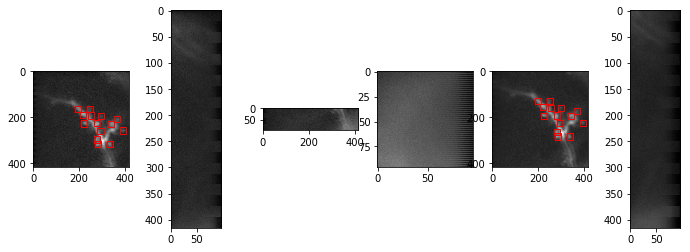

In [20]:
#Show a few sample split images with boxes
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(images_split_all[:n_img], range(n_img)):
    m_axs[ax_ind].imshow(img)
    if sum(boxes_split_all[ax_ind].shape) > 0:
        for box in boxes_split_all[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(box[:2],box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)

In [21]:
# get image shapes
img_df['shape'] = img_df['images'].map(lambda x: x.shape)
# img_df.sample(2)

In [22]:
# Calculate max dimensions
# max_y,max_x,max_z = 0,0,0
# for y,x,z in img_df['shape']:
#     max_x = np.max([max_x, x])
#     max_y = np.max([max_y, y])
#     max_z = np.max([max_z, z])
# max_y, max_x, max_z
max_y, max_x, max_z = IMAGE_HEIGHT, IMAGE_WIDTH, 3

In [23]:
# function to pad images and shift coordinates accordingly

def pad_image_and_shift_boxes(row):
    image = row['images']
    row['boxes_shifted'] = row['boxes'].copy()
    row['images_padded'] = image.copy()
    y,x,z = image.shape
    if image.shape == (max_y,max_x,max_z):
        return row
    pad_y, pad_x, pad_z = max_y - y, max_x - x, max_z - z
    y1,y2 = np.floor(pad_y/2).astype(int), np.floor(pad_y/2).astype(int) + pad_y%2
    x1,x2 = np.floor(pad_x/2).astype(int), np.floor(pad_x/2).astype(int) + pad_x%2
    z1,z2 = np.floor(pad_z/2).astype(int), np.floor(pad_z/2).astype(int) + pad_z%2
    row['images_padded'] = np.pad(image, ((y1,y2),(x1,x2),(z1,z2)), mode = 'constant')
    if row['boxes_shifted'] is None:
        return row
#     row['x_y_coordinates_shifted'][0] = row['x_y_coordinates'][0] + x1
#     row['x_y_coordinates_shifted'][1] = row['x_y_coordinates'][1] + y1
    if sum(row['boxes_shifted'].shape) >0: #to make sure it's not empty
#         print(row['boxes_shifted'][:,:2])
#         print(np.array([x1,y1]))
#         print('yes')
        if len(row['boxes_shifted'].shape)==1:
            row['boxes_shifted'] = np.reshape(row['boxes_shifted'],(-1,4))
        row['boxes_shifted'][:,:2] += np.array([x1,y1])
    return row

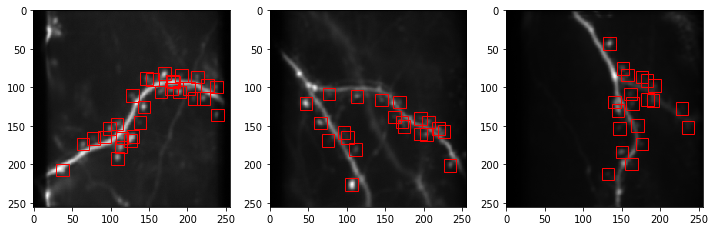

In [24]:
#Show a few sample split images with boxes
n_img = 3
index_offset = 0
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].loc[index_offset:n_img+index_offset], range(n_img)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['boxes'].loc[ax_ind+index_offset].shape) > 0:
        for pos in img_df['boxes'].loc[ax_ind+index_offset]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(pos[:2],pos[2],pos[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)


In [25]:
# a = np.array([[1,2],[3,4]])
# b = np.array([5,5])
# print(a)

In [26]:
#Apply padding to all images and shift coordinates respectively
img_df = img_df.apply(pad_image_and_shift_boxes, axis = 1)
img_df.loc[0]


bounding_boxes_path    C:\Users\smirnovm\Documents\Data\Labeled_Spine...
img_path               C:\Users\smirnovm\Documents\Data\Labeled_Spine...
info_path              C:\Users\smirnovm\Documents\Data\Labeled_Spine...
ImageID                                                           000001
boxes                  [[29.367, 199.37, 16.267, 16.267], [55.867, 16...
images                 [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [2, 2, 2], ...
split_image                                                        False
shape                                                      (256, 256, 3)
boxes_shifted          [[109.367, 279.37, 16.267, 16.267], [135.867, ...
images_padded          [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Name: 0, dtype: object

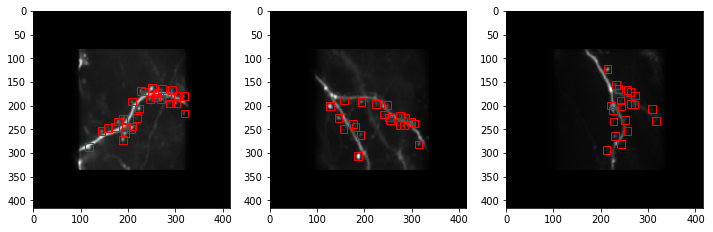

In [27]:
#Show a few sample split images with boxes
n_img = 3
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images_padded'].loc[:n_img], range(n_img)):
    m_axs[ax_ind].imshow(img)
    if sum(img_df['boxes_shifted'].loc[ax_ind].shape) > 0:
        for pos in img_df['boxes_shifted'].loc[ax_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(pos[:2],pos[2],pos[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)


[238, 128, 2375, 114, 6148, 1685, 4768, 5344, 3940]


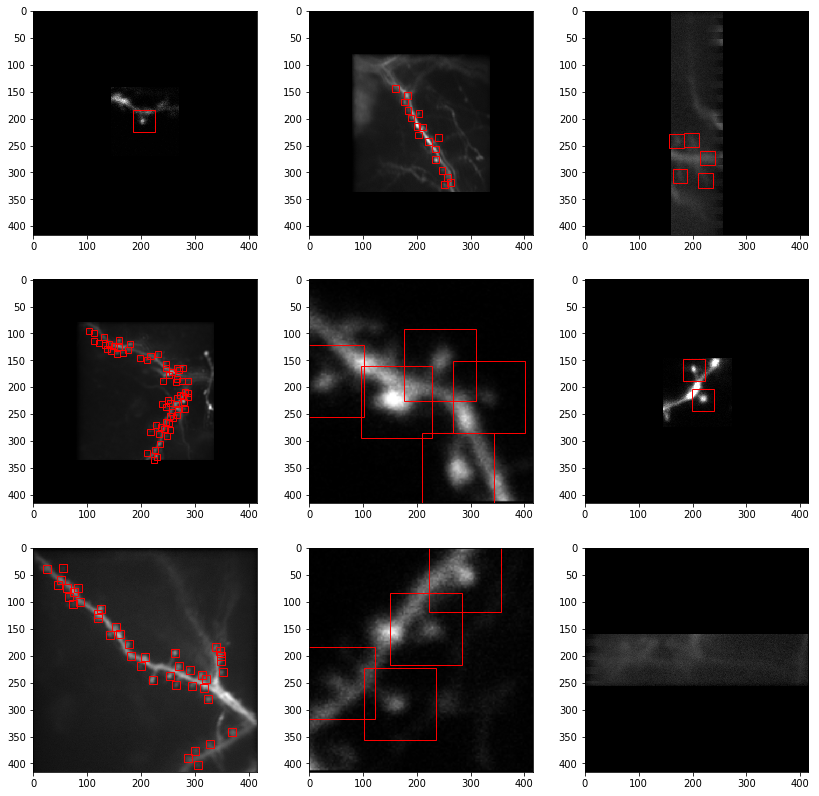

In [28]:
#Show a bunch of random sample images with boxes
n_img = 9
n_x_ax = 3
n_y_ax = 3
img_index = random.sample(range(len(img_df)),n_img)
print(img_index)
fig, m_axs = plt.subplots(n_y_ax, n_x_ax, figsize=(14,14))
for ax_ind, img_ind in zip(range(n_img), img_index):
    row = np.floor(ax_ind/n_y_ax).astype('uint8')
    col = ax_ind%n_x_ax
    m_axs[row,col].imshow(img_df['images_padded'].loc[img_ind])
    if sum(img_df['boxes_shifted'].loc[img_ind].shape) > 0:
        for pos in img_df['boxes_shifted'].loc[img_ind]:
#             x_rect = x-BOX_WIDTH/2
#             y_rect = y-BOX_HEIGHT/2
#             x_y_rect = xy-np.array([BOX_HEIGHT/2,BOX_WIDTH/2])
            rect = patches.Rectangle(pos[:2],pos[2],pos[3],linewidth=1,edgecolor='r',facecolor='none')
            m_axs[row,col].add_patch(rect)
plt.show(fig)


In [29]:
# function to make boxes match for yolo

def boxes_to_yolo_boxes(boxes):
    #boxes is an array of shape (num_boxes,5) containing 1D list of class, x_min, y_max, x_max, y_max.
    # class is always labeled as "1" for spine since that's the only thing we're looking for. DOOOEEEEEE
    yolo_boxes = []
    if sum(boxes.shape) > 0:
        for x,y,w,h in boxes:
            yolo_box = np.array([1, x,y, x+w,y+h])
            yolo_boxes.append(yolo_box)
    return np.array(yolo_boxes)


In [30]:
# # function to make images floats
# def preprocess_images_for_yolo(image):
#     image = image.astype(np.float)
#     image = image/255
#     return image

In [31]:
# # make images floats between 0 and 1
# img_df['images_yolo'] = img_df['images_padded'].map(preprocess_images_for_yolo)

In [32]:
#map boxes to yolo boxes
img_df['yolo_boxes'] = img_df['boxes_shifted'].map(boxes_to_yolo_boxes)
img_df.sample(2)

,bounding_boxes_path,img_path,info_path,ImageID,boxes,images,split_image,shape,boxes_shifted,images_padded,yolo_boxes
3037,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,000298,"[[2.769999999999982, 195.27, 22.453, 22.453], ...","[[[8, 8, 8], [6, 6, 6], [9, 9, 9], [8, 8, 8], ...",True,"(416, 96, 3)","[[162.76999999999998, 195.27, 22.453, 22.453],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[1.0, 162.76999999999998, 195.27, 185.2229999..."
6812,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,002569,"[[176.3086376811594, 125.69098507462687, 123.6...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",False,"(416, 416, 3)","[[176.3086376811594, 125.69098507462687, 123.6...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[1.0, 176.3086376811594, 125.69098507462687, ..."


In [33]:
# df_to_save = img_df.drop(columns = ['boxes','images','boxes_shifted','shape','split_image'])
# # df_to_save.sample(2)

In [34]:
# def set_dtype(x): return x.astype(np.uint8)
# images = img_df['images_padded'].map(set_dtype)
# image_array = np.array(images.as_matrix())
# # a_type = [x.dtype for x in image_array]
# image_array_uint8 = np.stack(image_array,axis = 0)

In [35]:
# image_array_uint8.shape
# hdf5_file.close()

In [39]:
# create padded array of all boxes
def create_padded_formatted_box_array(boxes, image_size):
    image_size = np.array(image_size)
    boxes = img_df['yolo_boxes'].as_matrix()
    # Box preprocessing.
    # Original boxes stored as 1D list of class, x_min, y_min, x_max, y_max.
    boxes = [box.reshape((-1, 5)) for box in boxes]
    # Get extents as y_min, x_min, y_max, x_max, class for comparision with
    # model output.
    boxes_extents = [box[:, [2, 1, 4, 3, 0]] for box in boxes]

    # Get box parameters as x_center, y_center, box_width, box_height, class.
    boxes_xy = [0.5 * (box[:, 3:5] + box[:, 1:3]) for box in boxes]
    boxes_wh = [box[:, 3:5] - box[:, 1:3] for box in boxes]
    boxes_xy = [boxxy / image_size for boxxy in boxes_xy]
    boxes_wh = [boxwh / image_size for boxwh in boxes_wh]
    boxes = [np.concatenate((boxes_xy[i], boxes_wh[i], box[:, 0:1]), axis=1) for i, box in enumerate(boxes)]

    # find the max number of boxes
    max_boxes = 0
    for boxz in boxes:
        if boxz.shape[0] > max_boxes:
            max_boxes = boxz.shape[0]

    # add zero pad for training
    for i, boxz in enumerate(boxes):
        if boxz.shape[0] < max_boxes:
            zero_padding = np.zeros((max_boxes - boxz.shape[0], 5), dtype=np.float32)
            boxes[i] = np.vstack((boxz, zero_padding))
    boxes = np.array(boxes)
    
    # avoid errors due to incorrect coordinates etc     
    boxes[boxes > 1] = 1
    boxes[boxes < 1] = 0
        
    return boxes

In [37]:
#save images to HDF5 File
file_name = 'spine_images.hdf5'
hdf5_file = h5py.File(file_name, mode='w')
hdf5_file.create_dataset("images", (len(img_df['images_padded']), IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), np.float)

# loop over images
# this probably doesn't need a loop? but maybe it does i guess so images are separate...
for i in range(len(img_df['images_padded'])):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print('Image data: {}/{}'.format(i, len(img_df['images_padded'])))
#     image_storage.append(image_array_uint8[i,:,:,:])
#     image_storage.append(np.expand_dims(img_df['images_padded'].loc[i],axis = 0))
    hdf5_file["images"][i, ...] = np.expand_dims(img_df['images_padded'].loc[i].astype(np.float)/255,axis = 0)
#     boxes_storage.append(img_df['yolo_boxes'])
# save the mean and close the hdf5 file
hdf5_file.close()
print('Image data save finished')

Image data: 1000/6818
Image data: 2000/6818
Image data: 3000/6818
Image data: 4000/6818
Image data: 5000/6818
Image data: 6000/6818
Image data save finished


In [40]:
# save boxes to hdf5 file array
file_name_boxes = 'spine_boxes.hdf5'
boxes = create_padded_formatted_box_array(img_df['yolo_boxes'].as_matrix(), (416,416))
hdf5_file_boxes = h5py.File(file_name_boxes, mode='w')
hdf5_file_boxes.create_dataset("boxes", data = boxes)
hdf5_file_boxes.close()

In [ ]:
# load sample underwater_data.npz to check what data should look like
# underwater_data = np.load('..//data//underwater_data.npz')

In [ ]:
# underwater_data['boxes'][50]

In [ ]:
#save two samples for testing training algorithm
# np.savez('spine_images_and_boxes_2_sample', images = images[220:222], boxes = boxes[220:222])

In [ ]:
images = img_df['images_padded'].loc[1:100].as_matrix()

In [ ]:
images = np.stack(images, axis = 0)

In [ ]:
X = images
X = X.astype(np.float) / 255
X = [np.squeeze(X[i, :, :, :]) for i in range(X.shape[0])]


In [ ]:
X_array = np.zeros((len(X),),dtype = np.object)
X_array.shape
for i in range(len(X)):
    X_array[i] = X[i]
X_array.shape

In [ ]:
X_array

In [ ]:
#test loading data
file_name ='spine_images_all.hdf5'

hdf5_file = tables.open_file(file_name, mode='r')
images_all =hdf5_file.root.images[:]
hdf5_file
hdf5_file.close()

In [ ]:
print(images_all.shape)
images_obj = [images_all[i,:,:,:] for i in range(images_all.shape[0])]
# images_obj = np.array(images_obj, dtype = np.object)
i_obj = np.array(images_obj[0])
# images_obj.shape
i_obj[0][0][0]

In [ ]:
images = [PIL.Image.fromarray(images_all[i,:,:,:]) for i in range(images_all.shape[0])]


In [ ]:
#test loading data
file_name ='spine_images_all.hdf5'

hdf5_file = h5py.File(file_name, "r")
images_all =hdf5_file["images"][:,...]
images_all.shape
hdf5_file.close()

In [ ]:
# images = [PIL.Image.fromarray(images_all[i,:,:,:]) for i in range(images_all.shape[0])]
images_all[1,:,:,:].dtype

In [ ]:
file_name ='spine_images_all.hdf5'
hdf5_file = h5py.File(file_name, "r")
hdf5_file["images"].shape

In [ ]:
ids = hdf5_file["images"].shape[0]
ids

In [ ]:
hdf5_file.close()

In [ ]:
hdf5_file = h5py.File(file_name, "r")
data_len = hdf5_file["images"].shape[0]


hdf5_file.close()

In [ ]:
partition = dict(training = np.array(range(int(0.9*data_len))), 
                 validation = np.array(range(int(0.9*data_len),data_len)))
partition

In [ ]:
boxes[0,...]

In [ ]:
true_boxes = boxes[0].copy()
box = true_boxes[0]
np.floor(box[1].astype(int))

In [ ]:

np.where(boxes > 1)
boxes[4582,22,0]
boxes[boxes > 1] = 1
np.where(boxes > 1)

In [1]:
import math


In [2]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [8]:
origin = [.5,.5]
point = [.1,.1]
angle = math.radians(10)
qx,qy = rotate(origin,point,angle)
print(qx,qy,angle)


0.1755361698618889 0.03661762772834465 0.17453292519943295


In [ ]:
np.sin()